# **Symbolic Solver**


In [1]:
import sympy as sp

# Declare symbols
λ, μ1, μ2, μ3 = sp.symbols('λ μ1 μ2 μ3', positive=True)
λ1, λ2, λ3 = sp.symbols('λ1 λ2 λ3')  # effective arrival rates

# Routing probabilities
p12, p23, p31 = sp.symbols('p12 p23 p31', positive=True)

# Define balance equations based on flow conservation
eq1 = sp.Eq(λ1, λ + p31 * λ3)       # Node 1: external λ + from Node 3
eq2 = sp.Eq(λ2, p12 * λ1)           # Node 2: from Node 1
eq3 = sp.Eq(λ3, p23 * λ2)           # Node 3: from Node 2

# Solve the system of equations for λ1, λ2, λ3
solutions = sp.solve([eq1, eq2, eq3], (λ1, λ2, λ3), dict=True)[0]

# Compute utilization for each node
rho1 = solutions[λ1] / μ1
rho2 = solutions[λ2] / μ2
rho3 = solutions[λ3] / μ3

# Display results
print("Effective arrival rates:")
print(f"λ1 = {solutions[λ1]}")
print(f"λ2 = {solutions[λ2]}")
print(f"λ3 = {solutions[λ3]}")

print("\nStability conditions (utilizations < 1):")
print(f"ρ1 = {rho1} < 1")
print(f"ρ2 = {rho2} < 1")
print(f"ρ3 = {rho3} < 1")

Effective arrival rates:
λ1 = -λ/(p12*p23*p31 - 1)
λ2 = -p12*λ/(p12*p23*p31 - 1)
λ3 = -p12*p23*λ/(p12*p23*p31 - 1)

Stability conditions (utilizations < 1):
ρ1 = -λ/(μ1*(p12*p23*p31 - 1)) < 1
ρ2 = -p12*λ/(μ2*(p12*p23*p31 - 1)) < 1
ρ3 = -p12*p23*λ/(μ3*(p12*p23*p31 - 1)) < 1


# **Simulator**


In [3]:
!pip install simpy
import simpy
import random
import numpy as np

# Parameters
λ = 10     # External arrival rate
μ1 = 30    # Service rate at Node 1
μ2 = 25    # Service rate at Node 2
μ3 = 20    # Service rate at Node 3
p12 = 0.7  # Probability of routing from Node 1 to Node 2
p23 = 0.8  # Probability of routing from Node 2 to Node 3
p31 = 0.5  # Probability of routing from Node 3 to Node 1

# Simulation time
SIM_TIME = 10000

class Node:
    def __init__(self, env, name, service_rate, routing_prob=1.0, next_node=None):
        self.env = env
        self.name = name
        self.service_rate = service_rate
        self.routing_prob = routing_prob
        self.next_node = next_node
        self.queue = simpy.Resource(env, capacity=1)
        self.queue_lengths = []
        self.delays = []
        self.jobs_completed = 0
        self.busy_time = 0
        self.last_start_time = None

    def process_job(self):
        with self.queue.request() as req:
            yield req
            self.queue_lengths.append(len(self.queue.queue))
            start_time = self.env.now
            service_time = random.expovariate(self.service_rate)
            self.last_start_time = start_time
            yield self.env.timeout(service_time)
            delay = self.env.now - start_time
            self.delays.append(delay)
            self.jobs_completed += 1
            self.busy_time += service_time

            # Route to next node with given probability
            if self.next_node and random.random() < self.routing_prob:
                self.env.process(self.next_node.process_job())

    def receive_job(self):
        self.env.process(self.process_job())

    def report_stats(self):
        utilization = self.busy_time / self.env.now
        avg_queue_length = np.mean(self.queue_lengths) if self.queue_lengths else 0
        avg_delay = np.mean(self.delays) if self.delays else 0
        print(f"\n--- Stats for {self.name} ---")
        print(f"Utilization: {utilization:.3f}")
        print(f"Avg Queue Length: {avg_queue_length:.3f}")
        print(f"Avg Delay: {avg_delay:.3f}")
        print(f"Jobs Completed: {self.jobs_completed}")

def external_arrivals(env, target_node, arrival_rate):
    while True:
        yield env.timeout(random.expovariate(arrival_rate))
        env.process(target_node.process_job())

# Set up the environment
env = simpy.Environment()

# Create nodes
node1 = Node(env, 'Node 1', μ1, routing_prob=p12)
node2 = Node(env, 'Node 2', μ2, routing_prob=p23)
node3 = Node(env, 'Node 3', μ3, routing_prob=p31)

# Set routing links
node1.next_node = node2
node2.next_node = node3
node3.next_node = node1

# Start receiving jobs
node1.receive_job()
node2.receive_job()
node3.receive_job()

# Only node1 receives external arrivals
env.process(external_arrivals(env, node1, λ))

# Run the simulation
env.run(until=SIM_TIME)

# Report statistics
node1.report_stats()
node2.report_stats()
node3.report_stats()


--- Stats for Node 1 ---
Utilization: 0.465
Avg Queue Length: 0.404
Avg Delay: 0.033
Jobs Completed: 139286

--- Stats for Node 2 ---
Utilization: 0.388
Avg Queue Length: 0.252
Avg Delay: 0.040
Jobs Completed: 97551

--- Stats for Node 3 ---
Utilization: 0.389
Avg Queue Length: 0.255
Avg Delay: 0.050
Jobs Completed: 77840


# **Validation of Simulation**


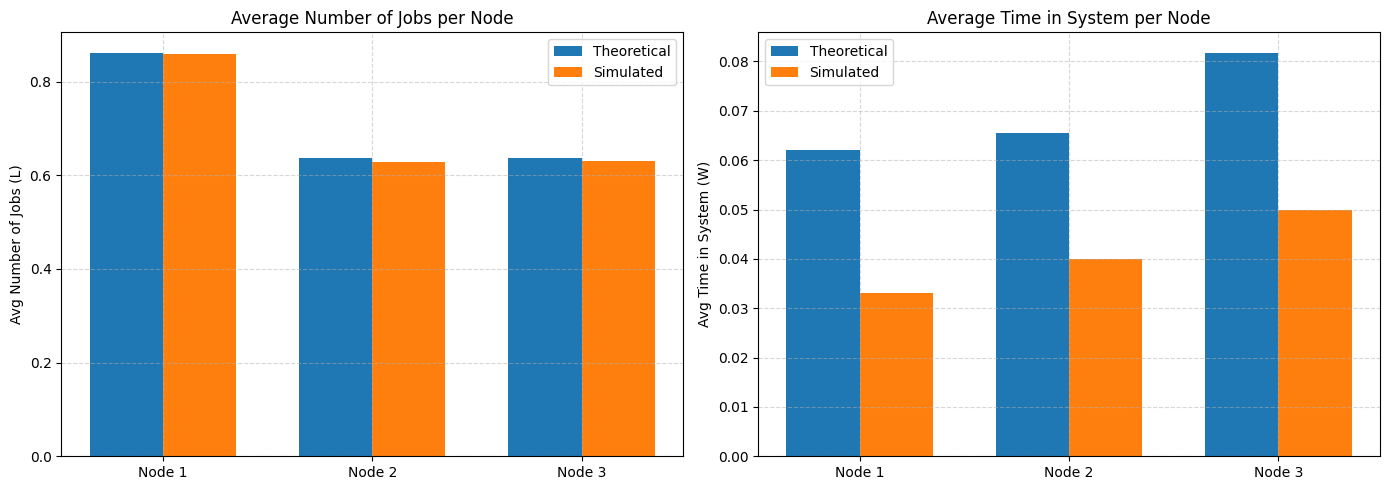

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
λ = 10     # External arrival rate
μ1 = 30    # Service rate at Node 1
μ2 = 25    # Service rate at Node 2
μ3 = 20    # Service rate at Node 3
p12 = 0.7  # Routing probability from Node 1 to Node 2
p23 = 0.8  # Routing probability from Node 2 to Node 3
p31 = 0.5  # Routing probability from Node 3 to Node 1

# Solve for arrival rates using Jackson network balance equations
# λ1 = λ_ext + p31 * λ3
# λ2 = p12 * λ1
# λ3 = p23 * λ2

A = p23 * p12 * λ
B = p23 * p12 * p31

λ3 = A / (1 - B)
λ1 = λ + p31 * λ3
λ2 = p12 * λ1

# Theoretical values (Jackson Network)
ρ1 = λ1 / μ1
ρ2 = λ2 / μ2
ρ3 = λ3 / μ3

L1 = ρ1 / (1 - ρ1)
L2 = ρ2 / (1 - ρ2)
L3 = ρ3 / (1 - ρ3)

W1 = L1 / λ1
W2 = L2 / λ2
W3 = L3 / λ3

theoretical_L = [L1, L2, L3]
theoretical_W = [W1, W2, W3]

# Simulated values (from the simulation results from part 4)
simulated_L = [0.859, 0.628, 0.631]  # Avg Queue Length + Utilization
simulated_W = [0.033, 0.040, 0.050]  # Avg Delay (assumed to include service time)


# Plotting
nodes = ['Node 1', 'Node 2', 'Node 3']
x = np.arange(len(nodes))
width = 0.35

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot: Average Number of Jobs (L)
ax[0].bar(x - width/2, theoretical_L, width, label='Theoretical')
ax[0].bar(x + width/2, simulated_L, width, label='Simulated')
ax[0].set_ylabel('Avg Number of Jobs (L)')
ax[0].set_title('Average Number of Jobs per Node')
ax[0].set_xticks(x)
ax[0].set_xticklabels(nodes)
ax[0].legend()
ax[0].grid(True, linestyle='--', alpha=0.5)

# Plot: Average Time in System (W)
ax[1].bar(x - width/2, theoretical_W, width, label='Theoretical')
ax[1].bar(x + width/2, simulated_W, width, label='Simulated')
ax[1].set_ylabel('Avg Time in System (W)')
ax[1].set_title('Average Time in System per Node')
ax[1].set_xticks(x)
ax[1].set_xticklabels(nodes)
ax[1].legend()
ax[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# **Experiments: Bottleneck Analysis**


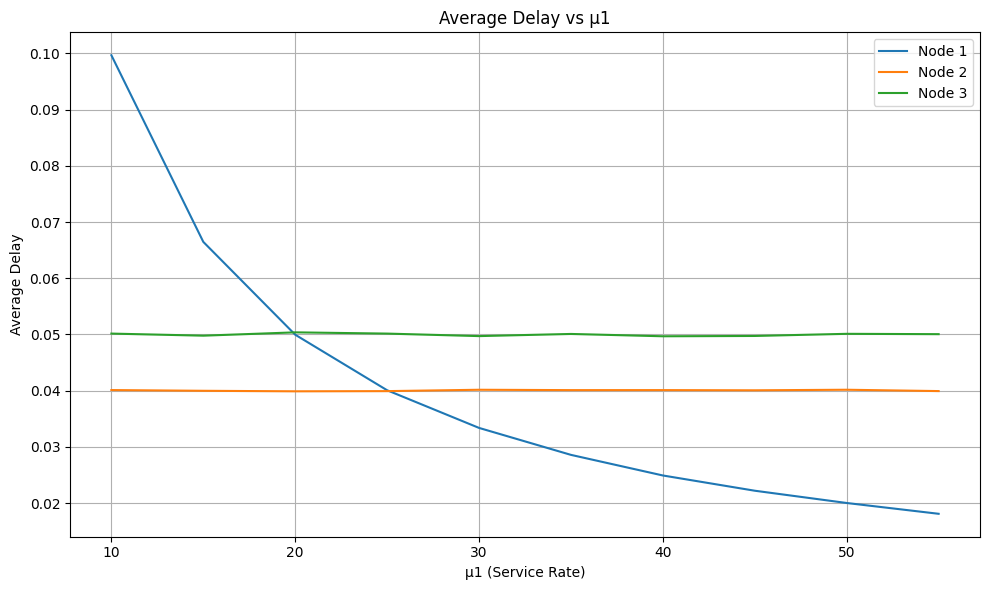

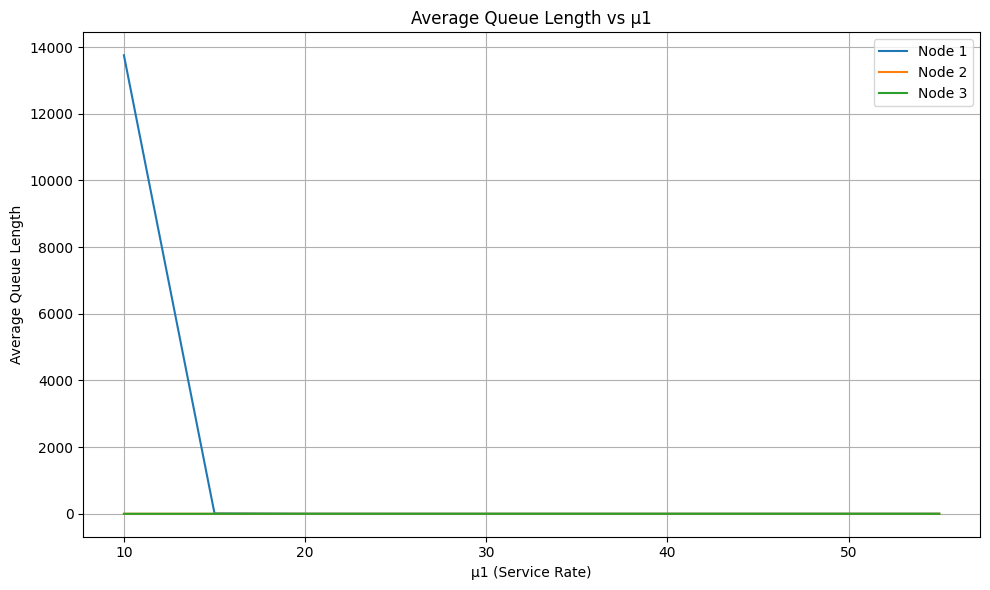

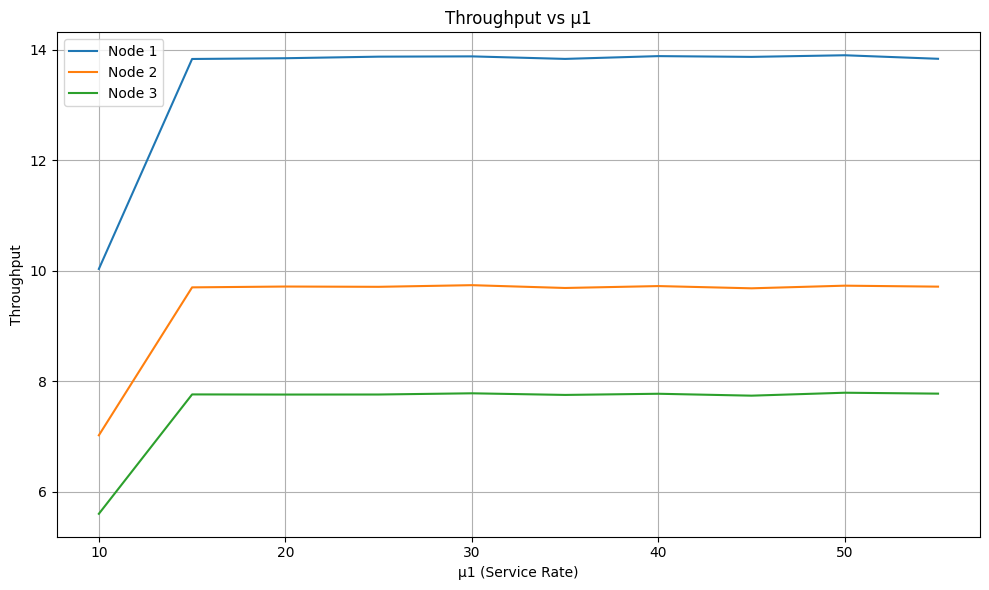

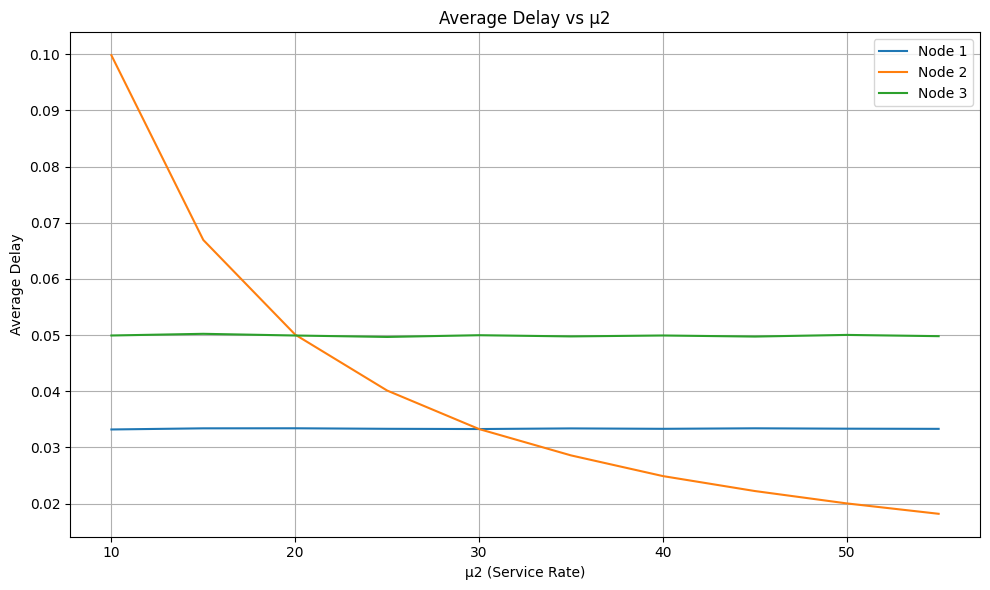

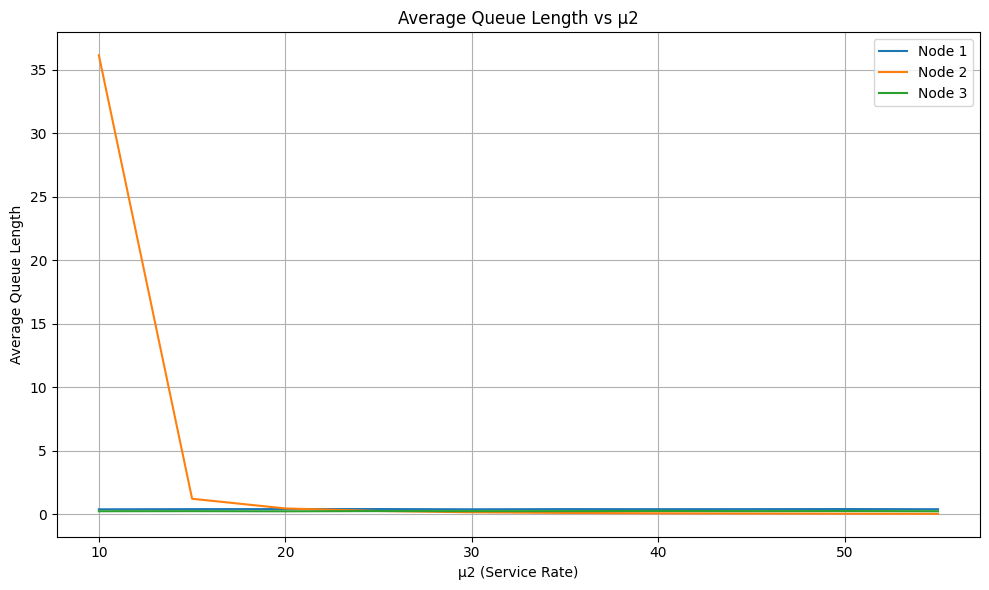

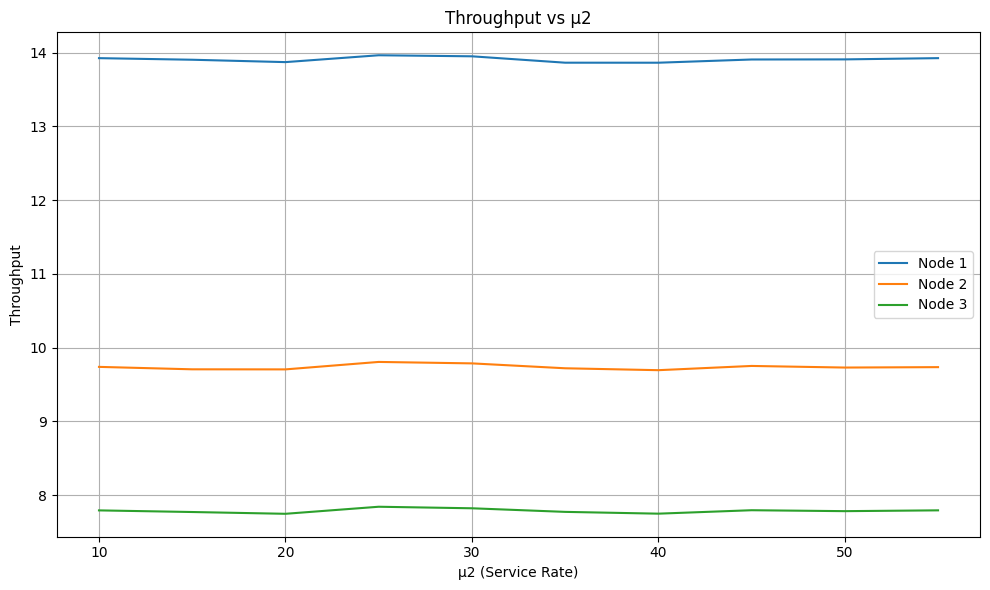

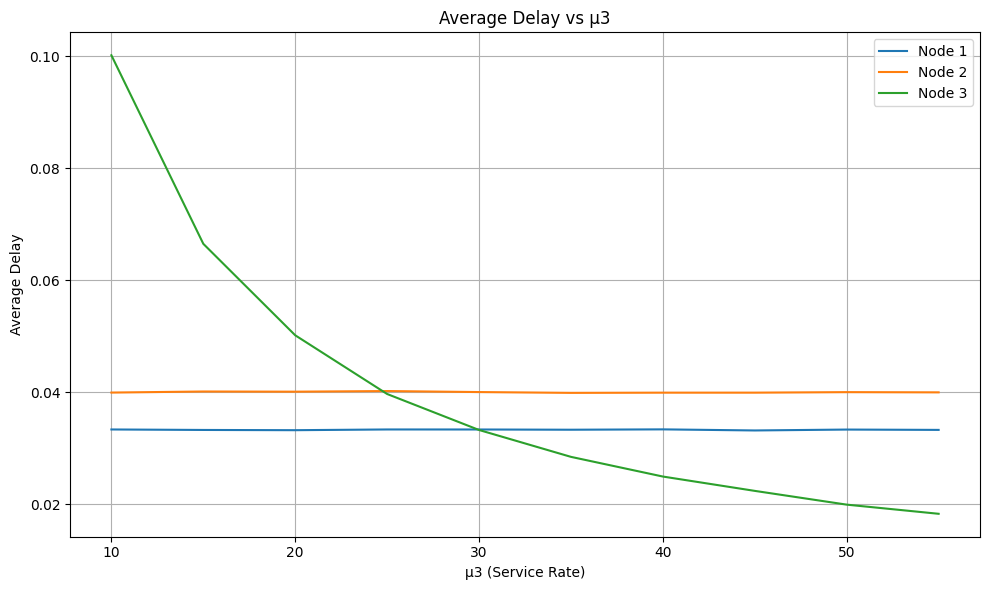

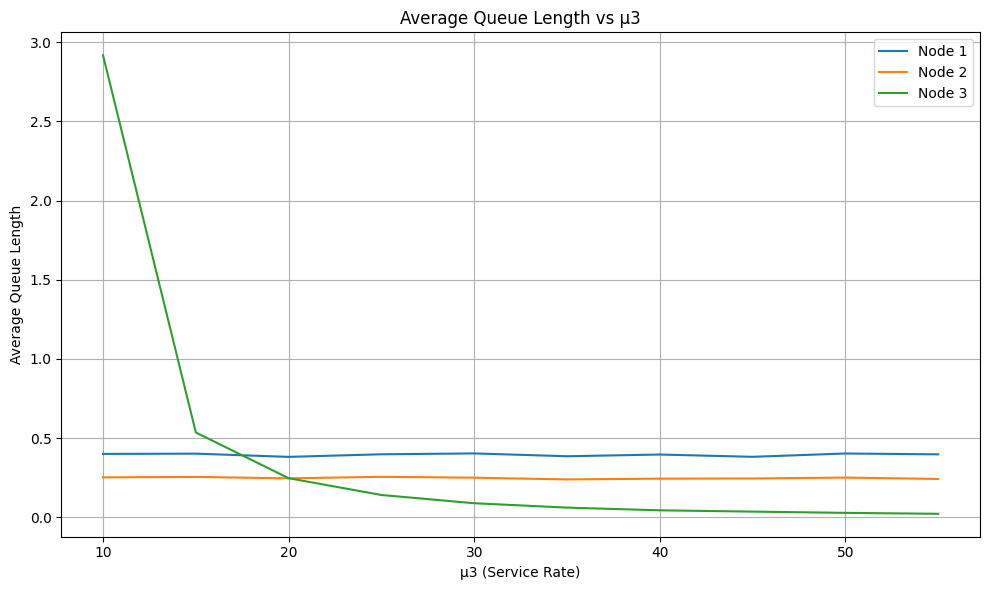

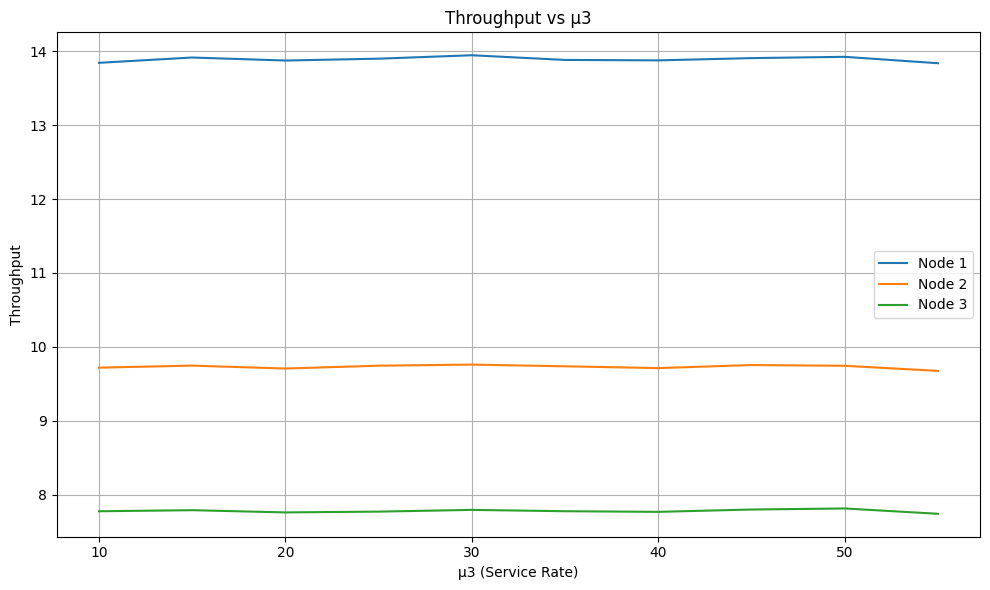

In [5]:
import simpy
import numpy as np
import random
import matplotlib.pyplot as plt

# Node class
class Node:
    def __init__(self, env, name, service_rate, routing_prob=1.0, next_node=None):
        self.env = env
        self.name = name
        self.service_rate = service_rate
        self.routing_prob = routing_prob
        self.next_node = next_node
        self.queue = simpy.Resource(env, capacity=1)
        self.queue_lengths = []
        self.delays = []
        self.jobs_completed = 0
        self.busy_time = 0

    def process_job(self):
        with self.queue.request() as req:
            yield req
            self.queue_lengths.append(len(self.queue.queue))
            start_time = self.env.now
            service_time = random.expovariate(self.service_rate)
            yield self.env.timeout(service_time)
            self.delays.append(self.env.now - start_time)
            self.busy_time += service_time
            self.jobs_completed += 1
            if self.next_node and random.random() < self.routing_prob:
                self.env.process(self.next_node.process_job())

# External arrivals
def external_arrivals(env, target_node, arrival_rate):
    while True:
        yield env.timeout(random.expovariate(arrival_rate))
        env.process(target_node.process_job())

# Simulation runner
def run_simulation(μ1, μ2, μ3, sim_time=10000, λ=10, p12=0.7, p23=0.8, p31=0.5):
    env = simpy.Environment()

    node1 = Node(env, 'Node 1', μ1, routing_prob=p12)
    node2 = Node(env, 'Node 2', μ2, routing_prob=p23)
    node3 = Node(env, 'Node 3', μ3, routing_prob=p31)

    node1.next_node = node2
    node2.next_node = node3
    node3.next_node = node1

    env.process(external_arrivals(env, node1, λ))
    env.run(until=sim_time)

    return {
        'Node 1': {
            'avg_delay': np.mean(node1.delays),
            'avg_queue': np.mean(node1.queue_lengths),
            'throughput': node1.jobs_completed / sim_time,
        },
        'Node 2': {
            'avg_delay': np.mean(node2.delays),
            'avg_queue': np.mean(node2.queue_lengths),
            'throughput': node2.jobs_completed / sim_time,
        },
        'Node 3': {
            'avg_delay': np.mean(node3.delays),
            'avg_queue': np.mean(node3.queue_lengths),
            'throughput': node3.jobs_completed / sim_time,
        }
    }

# Plotting function
def plot_metric(x_values, y_values, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    plt.plot(x_values, y_values[0], label='Node 1')
    plt.plot(x_values, y_values[1], label='Node 2')
    plt.plot(x_values, y_values[2], label='Node 3')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Sensitivity Analysis Function
def sensitivity_analysis(vary_node):
    values = np.arange(10, 60, 5)
    fixed_μ = {'μ1': 30, 'μ2': 25, 'μ3': 20}

    delays, queues, throughputs = [[], [], []], [[], [], []], [[], [], []]

    for v in values:
        μ1 = v if vary_node == 'μ1' else fixed_μ['μ1']
        μ2 = v if vary_node == 'μ2' else fixed_μ['μ2']
        μ3 = v if vary_node == 'μ3' else fixed_μ['μ3']
        stats = run_simulation(μ1, μ2, μ3)

        for i, node in enumerate(['Node 1', 'Node 2', 'Node 3']):
            delays[i].append(stats[node]['avg_delay'])
            queues[i].append(stats[node]['avg_queue'])
            throughputs[i].append(stats[node]['throughput'])

    plot_metric(values, delays, f'Average Delay vs {vary_node}', f'{vary_node} (Service Rate)', 'Average Delay')
    plot_metric(values, queues, f'Average Queue Length vs {vary_node}', f'{vary_node} (Service Rate)', 'Average Queue Length')
    plot_metric(values, throughputs, f'Throughput vs {vary_node}', f'{vary_node} (Service Rate)', 'Throughput')

# Run analyses for μ1, μ2, μ3
sensitivity_analysis('μ1')
sensitivity_analysis('μ2')
sensitivity_analysis('μ3')